In [138]:
using Pkg; Pkg.activate("..")
using Base.Threads: @spawn
Threads.nthreads()

  Activating environment at `~/.julia/dev/PRONTO.jl/Project.toml`


1

# N-Link Inverted Pendulum
## Motivation

Multi-link inverted pendulum type systems arise in various applications, such as serial robotic arms. In the study of bipedal locomotion, the compass-gait model is one of the simplest models. It is a two-link inverted pendulum with a torque input about the "hip" joint. Adding "knees" to this model turns it into a four-link inverted pendulum. 

It should not be necessary to rederive the dynamics for every additional link added to the system, as the position and velocity of the new mass should be a function of those of the previous masses/links and the added generalized coordinate. Therefore I thought it would be an interesting problem to derive the dynamics of an inverted pendulum system with an arbitrary number of links.

The state of the system can be described by the angle of each link relative to the previous link, or as the angle of each joint relative to the inertial y-axis. These angles can be arbitrarily large so no small-angle approximations can be made. To derive this model it isn't necessary to apply any simplifying assumptions, however applying this model to any real-world system would of course require certain assumptions.

For this project I took the inputs to be torque applied at each joint, all of which can be independent and time-varying.

## Equations of Motion
Initially, I defined the geometric relationships in terms of the relative angles between links. However, it quickly became clear that the absolute angles would lead to cleaner equations of motion due to how dynamics propagate through the system; i.e. that when one angle changes, all of the following links are affected.

Relative angles θ can be transformed into cumulative angles ϕ using: 

$$ \vec{ϕ} = L\vec{θ} $$

Where L is a lower-triangular matrix of ones of dimension NxN. The time derivatives can be transformed using the same matrix L.

The only parameters needed to define the model are a vector of point masses $\vec{m}$ and a link length $l$. This model could be generalized to account for varying link lengths similar to varying masses.

The equations of motion can be written in the form:

$$ 
M(\vec{ϕ}) \ddot{\vec{ϕ}} + C(\vec{ϕ}, \dot{\vec{ϕ}}) + G(\vec{ϕ}) = L \vec{T}
$$

Where:
$$
M(\vec{ϕ}) = [M_{ij}], M_{ij} = m_{ij} l^2 \text{cos}(ϕ_i - ϕ_j) , where m_{ij} =  ∑_{k=\text{max}(i,j)}^{N} m_k
$$

$$
C(\vec{ϕ}, \dot{\vec{ϕ}}) = [C_{ij}] \dot{\vec{ϕ}}, C_{ij} = m_{ij} l^2 (\dot{ϕ_j} - 2\dot{ϕ_i}) \text{sin}(ϕ_i - ϕ_j)
$$

$$
G(\vec{ϕ}) = [G_i], G_i = -m_{ii} g l \text{sin}(ϕ_i)
$$

M contains the inertial/acceleration terms, C contains the coriolis terms, and G contains the body force/gravity terms. L is the same transformation matrix as shown previously, and T is the control input vector of torques.

## Equilibrium

Equilibium is achieved when all the angles are not changing. With no torque inputs, the only equilibrium states are where each ϕᵢ is either 0 or a multiple of π.

For externally applied torque, the following equation can be solved to find the torque input at any state:

$$ 
T = L^{-1} G(\vec{phi})
$$

## Simulation

The system free response was tested for an initial displacement of 

The attached video shows the simulation of the system.




In [169]:
using DifferentialEquations
using LinearAlgebra
using Colors
using ColorSchemes
set_alpha(CLR::T, alpha) where {T} = coloralpha(T)(CLR.r, CLR.g, CLR.b, alpha)

set_alpha (generic function with 1 method)

In [171]:
# interactive, standalone window
using GLMakie
GLMakie.activate!()

In [141]:
# inline plots
using CairoMakie
CairoMakie.activate!(type = "png")
CairoMakie.activate!(type = "svg")

In [191]:
clr_bg = parse(RGBAf, "#272822") # background
clr_mg = parse(RGBAf, "#8E8A73") # mid-ground
clr_fg = :white # fg

clr_set = [
    parse(RGBAf, "#0072BD"), # blue
    parse(RGBAf, "#D95319"), # orange/red
    parse(RGBAf, "#EDB120"), # yellow
    parse(RGBAf, "#7E2F8E"), # purple
    parse(RGBAf, "#009E73FF"), # teal
]

set_theme!(Theme(
    resolution = (1500, 1000),
    textcolor = :white,
    linewidth = 3,
    fontsize = 16,
    font = "Inter",
    color = clr_fg,
    palette = (
        color = clr_set,
    ),
    markercolor = :white,
    backgroundcolor = clr_bg,
    Axis = (
        backgroundcolor = clr_bg,
        xgridcolor = clr_mg,
        ygridcolor = clr_mg, 
        topspinecolor = clr_mg, 
        rightspinecolor = clr_mg,
        leftspinecolor = clr_mg, 
        bottomspinecolor = clr_mg,
        xtickcolor = clr_mg,
        ytickcolor = clr_mg,
    ),
))


In [201]:
## -------------------- plotting helper functions --------------------- ##

function phi2xy(ϕ, i)
    x = -l*sum(sin.(ϕ[1:i]))
    y = l*sum(cos.(ϕ[1:i]))
    return x, y
end

function phis2points(ϕvec)
    return [Point2f(phi2xy(ϕvec, i)) for i=1:N]
end

function colortomap(color, len)
    # Colors.lsequential_palette(color.h, )
    colortype = typeof(color)
    white = parse(colortype, :white)
    clear = set_alpha(color, 0)
    cmap = range(clear, stop=color, length=len)
    return cmap
end

function kinetic(x)
    ϕ = x[1:N]
    ϕd = x[N+1:end]
    T = 0
    for i = 1:N
        T += 1/2 * l^2 * m[i] * sum(sum([ϕd[j] * ϕd[k] * cos(ϕ[j]-ϕ[k]) for j = 1:i, k=1:i]))
    end
    return T
end

function potential(x)
    ϕ = x[1:N]
    V = 0
    for i = 1:N
        V += m[i] * g * l * sum([cos(ϕ[j]) for j = 1:i])
    end
    return V
end

function ϕdϕ(x)
    n = Int(length(x)/2)
    return (x[1:n], x[n+1:end])
end

function getϕ(x)
    n = Int(length(x)/2)
    return x[1:n]
end

getϕ (generic function with 1 method)

In [166]:
# plotting code
function make_plots(x)
    t = x.t[1]:0.01:x.t[end]
    ϕt = [map(tx->x(tx)[ix], t) for ix in 1:N]
    dϕt = [map(tx->x(tx)[ix], t) for ix in N+1:2N]

    fig = Figure()
    axs = Axis[]

    ax = Axis(fig[1,1]; title="ϕ(t)", xlabel = "Time (s)", ylabel = "ϕ (rad)")
    push!(axs, ax)
    for (i, ϕ) in enumerate(ϕt)
        lines!(ax, t, ϕ, label = "ϕ$i")
    end
    # axislegend()

    ax = Axis(fig[2,1]; title="dϕ(t)", xlabel = "Time (s)", ylabel = "dϕ (rad/s)")
    push!(axs, ax)
    for (i, dϕ) in enumerate(dϕt)
        lines!(ax, t, dϕ, label = "dϕ$i")
    end
    # axislegend()

    ax = Axis(fig[1,2]; title="G(t)", xlabel = "Time (s)", ylabel = "G (N∘m)")
    push!(axs, ax)
    for ix in 1:N
        lines!(ax, t, map(tx->G(x(tx)[1:N])[ix], t), label = "G[$ix]")
    end
    # axislegend()

    # map(tx->C(ϕdϕ(x(tx))...), t)
    ax = Axis(fig[2,2]; title="C(t)", xlabel = "Time (s)", ylabel = "C (N∘m)")
    push!(axs, ax)
    for ix in 1:N
        lines!(ax, t, map(tx->C(ϕdϕ(x(tx))...)[ix], t), label = "C[$ix]")
    end
    # axislegend()

    # @. potential(getϕ(x(t)))
    ax = Axis(fig[1:2,3]; title="energy")
    push!(axs, ax)
    lines!(ax, t, @. potential(x(t)); label = "Potential")
    lines!(ax, t, @. kinetic(x(t)); label = "Kinetic")
    lines!(ax, t, @. potential(x(t)) + kinetic(x(t)); label = "Total")
    # axislegend(ax)
    
    display(fig)
    return (fig, axs)
end

make_plots (generic function with 1 method)

In [203]:
## ---------------------------- build ODE ------------------------------ ##

# parameters
g = 9.8
l = 1
N = 4
# m = [1, 20, 1, 1]
m = ones(N)
T = t -> zeros(N)

tspan = (0.0, 20.0)
θ₀ = zeros(N)
θ₀[N] = π/2
θd₀ = zeros(N)

# dynamics
# mass matrix M:
U = UpperTriangular(ones(N,N))
L = LowerTriangular(ones(N,N))
Linv = inv(L)
v1 = ones(N)

# ℳ =  (U * m) .* I(N)
ℳvec = (U * m) 
ℳ = [ℳvec[ max(i,j)] for i in 1:N, j in 1:N]
𝒞 = ϕ -> [cos(ϕ[i] - ϕ[j]) for i in 1:N, j in 1:N]
M = ϕ -> l^2 .* ℳ .* 𝒞(ϕ)
# M = ϕ -> [  sum(
#                 [  [ l^2 * m[i] * cos(ϕ[a]-ϕ[j]) for j in 1:i ]
#                 for i in a:N]
#                 ) 
#             for a in 1:N]

C = (ϕ, ϕd) ->[ sum(
                    [ sum(
                        [ l^2 * m[i] * sin(ϕ[a]-ϕ[j]) * ϕd[j]^2 
                        for j in 1:i ]) 
                    for i in a:N]) 
                for a in 1:N]

# body force vector G:
G = ϕ -> @. -g*l*ℳvec*sin(ϕ)


# ODE solver formulation:
function f!(dx, x, T, t)
    # L: θ -> ϕ, Linv: ϕ -> θ
    θ = x[1:N]; θd = x[N+1:end]
    ϕ = L * θ
    ϕd = L * θd
    θdd = Linv*inv(M(ϕ)) * (-C(ϕ, ϕd) - G(ϕ) + Linv*T(t))
    dx[1:N] = θd; dx[N+1:end] = θdd
end

function fϕ!(dx, x, T, t)
    # x = [ϕ,dϕ], dx = [dϕ,ddϕ]
    ϕ = x[1:N]
    dϕ = dx[1:N] .= x[N+1:end]
    dx[N+1:end] .= inv(M(ϕ)) * (-C(ϕ, dϕ) - G(ϕ) + Linv*T(t))
end


fϕ! (generic function with 1 method)

In [205]:
## ---------------------------- solve ODE ------------------------------ ##

x = solve(ODEProblem(fϕ!, [θ₀; θd₀], tspan, T));
# x = solve(ODEProblem(fϕ!, [θ₀; θd₀], tspan, T), Rosenbrock23()) # matlab ode23s
# x = solve(ODEProblem(fϕ!, [θ₀; θd₀], tspan, T), TRBDF2())
# x = solve(ODEProblem(fϕ!, [θ₀; θd₀], tspan, T), BS3()) ;# matlab ode23


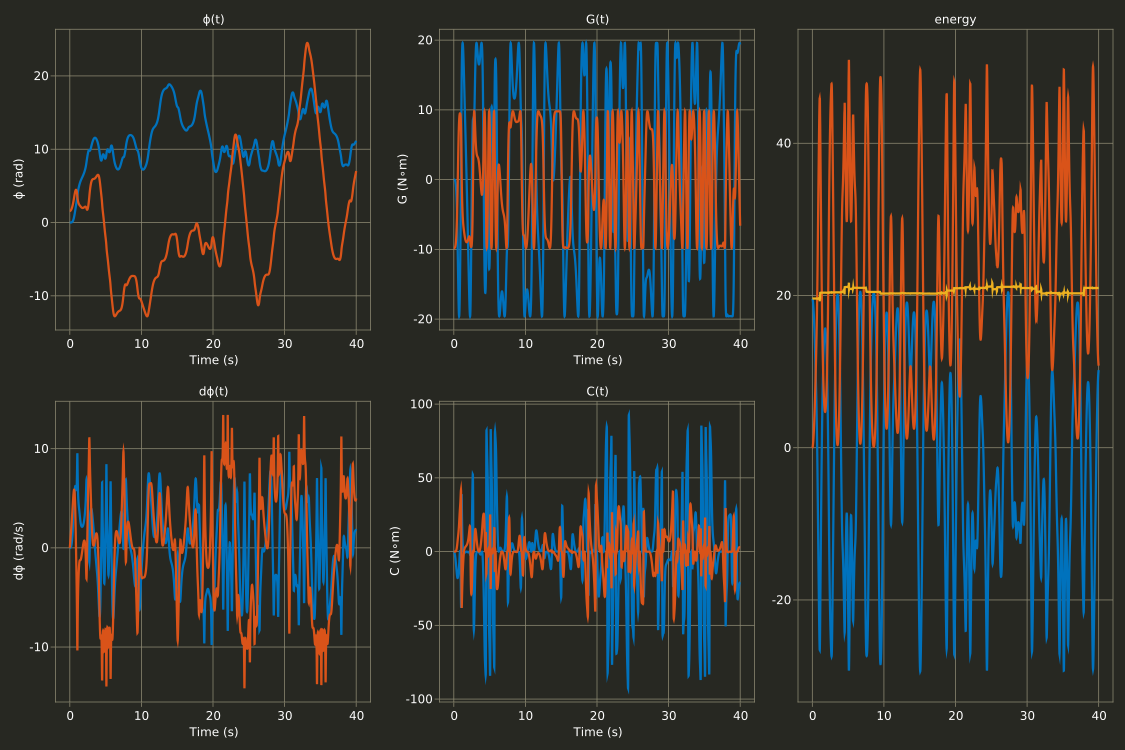

(Scene (1500px, 1000px):
  90 Plots:
    ├ Combined{Makie.poly, Tuple{Vector{Vector{Point{2, Float32}}}}}
    ├ LineSegments{Tuple{Vector{Point{2, Float32}}}}
    ├ LineSegments{Tuple{Vector{Point{2, Float32}}}}
    ├ LineSegments{Tuple{Vector{Point{2, Float32}}}}
    ├ LineSegments{Tuple{Vector{Point{2, Float32}}}}
    ├ LineSegments{Tuple{Vector{Point{2, Float32}}}}
    ├ LineSegments{Tuple{Vector{Point{2, Float32}}}}
    ├ MakieCore.Text{Tuple{String}}
    ├ Lines{Tuple{Vector{Point{2, Float32}}}}
    ├ MakieCore.Text{Tuple{Vector{Tuple{AbstractString, Point{2, Float32}}}}}
    ├ LineSegments{Tuple{Vector{Point{2, Float32}}}}
    ├ LineSegments{Tuple{Vector{Point{2, Float32}}}}
    ├ MakieCore.Text{Tuple{String}}
    ├ Lines{Tuple{Vector{Point{2, Float32}}}}
    ├ MakieCore.Text{Tuple{Vector{Tuple{AbstractString, Point{2, Float32}}}}}
    ├ Lines{Tuple{Vector{Point{2, Float32}}}}
    ├ Lines{Tuple{Vector{Point{2, Float32}}}}
    ├ MakieCore.Text{Tuple{String}}
    ├ Combined{Makie.p

In [167]:
fig, _ = make_plots(x);
# save("N2.png", fig)

In [206]:
## ---------------------------- simulate ------------------------------ #
fps = 120
dt = 1/fps
tvec = x.t[1]:dt:x.t[end]
numt = length(tvec)
ICpoints = phis2points(θ₀)
points = Node( [Node( [Point2f(ICpoints[i])] ) for i=1:N] )

time = Node( [Float64(0.0)] )
links = Node( [[Point2f(0.0,0.0)]; [Point2f(ICpoints[i]) for i=1:N]] )
println(links)
# KE = Node( [Float64(kinetic([θ₀; θd₀]))] )
# PE = Node( [Float64(potential([θ₀; θd₀]))] )
# totE = Node( [Float64(KE[][1]+PE[][1])])

colorsc = ColorSchemes.hawaii
# colorvec = [colorsc[i/N] for i = 0:N-1]
colorvec = [clr_set[i] for i = 1:N]
colormaps = [colortomap(colorvec[i], length(tvec)) for i in 1:N]
colors = Node( [Node( [Int(0)] ) for i=1:N] )

lim = N*l
fig = Figure()
ax1 = Axis(fig[1, 1], limits=(-lim, lim, -lim, lim))
ax1.aspect = AxisAspect(1)
# ax2 = Axis(fig[1, 2], limits = (tspan[1], tspan[2], nothing, nothing))
scatter!(ax1, points[][1], color = colors[][1], colormap = colormaps[1],
    transparency = true)

lines!(ax1, links, color = :black)
for i = 2:N
    scatter!(ax1, points[][i], color = colors[][i], colormap = colormaps[i])
end

# lines!(ax2, time, KE, color = :red)
# lines!(ax2, time, PE, color = :blue)
# lines!(ax2, time, totE, color = :purple)

fig
##

record(fig, "Npend.mp4", 2:numt, framerate = fps) do frame
    t = tvec[frame]
    # println(t)
    new_points = phis2points(x(t)[1:N])
    for i = 1:N
        points[][i][] = push!(points[][i][], new_points[i])
        colors[][i][] = (numt-frame):numt
        links[][i+1] = new_points[i]
    end
    # ke = kinetic(x(t))
    # pe = potential(x(t))
    # f!(dx, x(t), T, t)

    # ϕ = x(t)[1:N]; ϕd = x(t)[N+1:end]
    # θdd = inv(M(ϕ)) * (-C(ϕ, ϕd) - G(ϕ) + Linv*T(t))
    # println("KE ", ke)
    # println("PE ", pe)
    # println(dx)
    push!(time[], t)
    # push!(KE[], ke)
    # push!(PE[], pe)
    # push!(totE[], ke+pe)

    sleep(1/fps)
    notify.((points[]))
    notify(links)
    # notify.([KE, PE, time])
end

Observable{Vector{Point{2, Float32}}} with 0 listeners. Value:
Point{2, Float32}[[0.0, 0.0], [-0.0, 1.0], [-0.0, 2.0], [-0.0, 3.0], [-1.0, 3.0]]


"Npend.mp4"